In [17]:
using Revise
using Pkg; Pkg.activate(".")

using Dates
using Statistics
# using Rotations
using Interpolations
# using DSP
# using FFTW
using NCDatasets
using JLD2
using Printf

include("./read_lidar.jl")
using .read_lidar
using .read_lidar.stare
# using .read_vecnav: read_vecnav_dict
# import .chunks
# include("./timing_lidar.jl")
# using .timing_lidar
include("./readers.jl")
using .NoaaDas: cat_dicts
# using MAT

using PyPlot
using PyCall
using PyCall: PyObject

# PyObject method interprets Array{Union{T,Missing}} as a
# numpy masked array.
# This allows for plotting with missing values.
function PyObject(a::Array{Union{T,Missing},N}) where {T,N}
    numpy_ma = PyCall.pyimport("numpy").ma
    pycall(numpy_ma.array, Any, coalesce.(a,zero(T)), mask=ismissing.(a))
end

  Activating project at `~/Projects/ASTRAL/lidar`


PyObject

In [18]:
# function library with utility functions,  functions for subsetting, for displacements, and for structure functions

# utility functions
pd = permutedims
m2n(x) = ismissing(x) ? NaN : x
good(x) = !ismissing(x) & isfinite(x)

"""
    binavg(y, x, b; f=identity, w=y->1)
Bin average y(x) in bins b of coordinate x.
Skip missing by passing the optional function arguments
f(y) = ismissing(y) ? 0 : y;   w(y) = !ismissing(y)
"""
function binavg(y, x, b; f=identity, w=y->1)
    a = zeros(length(b))
    c = zeros(length(b))
    for (i,x) in enumerate(x)
        bi = findlast(j -> j < x, b) # findlast(<(x), b)
        a[bi] += f(y[i])
        c[bi] += w(y[i])
    end
    return a./c
end

# functions for masking and averaging data

"NaN -> missing"
n2m(x) = isfinite.(x) ? x : missing

"result is x; set to missing iff i<thr"
masklowi(x, i, thr=1.03) = i<thr ? missing : x

"mean along dimension dims, skipping missing"
missmean(X; dims=1) = mapslices(x -> mean(skipmissing(x)), X, dims=dims)

"anomaly"
anom(x; dims=1) = x.-mean(x; dims=dims)

# highpass filter
"""
hp(x, fcutoff=1/80)    highpass filter x,
by default filtfilt 4th-order Butterworth, fs=1
"""
function hp(x, fcutoff=1/80;
    order=4,
    designmethod=Butterworth(order), 
    fs=1,
    responsetype = Highpass(fcutoff; fs=fs) )
    
    filtfilt(digitalfilter(responsetype, designmethod), x)
end


# make simple linear temporal interpolation
# maybe fast
# most time is spent searching for indices
# indices are monotonic

"""
Return all the indices i such that each xl[i] is the first >= each xs.
Assumes xs, xl are ordered and loops through xs only once.
Quarry for needles xs in haystack xl.
"""
function findindices(xs, xl)
    # needles xs define quarries in haystack xl
    xs = filter(x -> x<=last(xl), xs) # prefilter to avoid running off the end of xl
    ind = zeros(Int64, size(xs))
    i = 1
    for (j,x) in enumerate(xs)
        while xl[i] < x
            i += 1
        end
        ind[j] = i
    end
    return ind
end

"average xl within windows to right of points of the index ind of xl"
function indavg(xl, ind; full=20)
    xm = zeros(Float64, size(ind))
    for (i,idx) in enumerate(ind)
        ii = max(1,idx) : min(length(xl),idx+full)
        # xm[i] = sum(Float64.(xl[ii])) / (full+1)
        xm[i] = mean(Float64.(xl[ii]))
    end
    return xm
end

# test data (precompiles)
let xl = 1:60_000_000, xs = 20:20:60_000_000
    ind = findindices(xs, xl)
    indavg(xl, ind)
end

# Adjust true vertical velocity for relative wind * sin(tilt)
# and the platform velocity
trigs(pitch, roll) = ( cos(pitch), sin(pitch), cos(roll), sin(roll) )
# cospitch, sinpitch, cosroll, sinroll = trigs(pitch, roll)

function wtrue_trigs(w, Ur, Vr, pitch, roll)
    # approximate, better to use rotations
    cospitch, sinpitch, cosroll, sinroll = trigs(pitch, roll)
    wtrue = ( w + Ur*sinpitch - Vr*cospitch*sinroll ) / (cospitch*cosroll)
end

"""
wtrue(dopplervel, Ur, Vr, heaveveldown, roll, pitch)
Return true radial velocity component in lidar beam frame (+away).
Rotate vertical VelNED and mean ship-relative wind (Ur, Vr)
from inertial level ship coorindates 
to lidar beam coordinates using roll and pitch.
"""
function wtrue( dopplervel, Ur, Vr, heaveveldown, roll, pitch )
    # external ship frame
    vvn_ship = [0, 0, heaveveldown] # VectorNav vertical velocity vector (NED coordinate)
    wnd_ship = [Ur, Vr, 0]          # mean horizontal relative wind, w=0 (NED coordinate)
    wnd_vn_ship = wnd_ship - vvn_ship

    # rotate from ship NED frame to lidar NED frame
    R = RotX(roll*π/180) * RotY(pitch*π/180)

    # mean vertical-radial-lidar relative velocity in the lidar platform body frame (NED)
    # includes heave-induced velocity
    wnd_lidar =  R * wnd_vn_ship # lidar NED frame (down-positive) vector

    # signs: lidar upward heave vel > 0 ==> lidar VelNED2 < 0, induced radial velocity < 0 (towards)

    # scalar true radial velocity (+up), adjusting for heave velocity
    # and mean wind component in beam direction.
    # wturb and dopplervel is away-positive. true radialvel is dopplervel + platform vel
    # wtrue = wrel + wplatform
    # trueradialvel is +up
    trueradialvel = dopplervel + -wnd_lidar[3] # negate downward wnd_lidar: NED +down, dopplervel +up
end

function wtrue( dopplervel, surgevel, swayvel, heaveveldown, Ur, Vr, roll, pitch )
    # external ship frame
    vvn_ship = [surgevel, swayvel, heaveveldown] # VectorNav vertical velocity vector (NED coordinate)
    #vvn_ship = [VelNED0, VelNED1, VelNED2]
    wnd_ship = [Ur, Vr, 0]          # mean horizontal relative wind, w=0 (NED coordinate)
    wnd_vn_ship = wnd_ship - vvn_ship

    # rotate from ship NED frame to lidar NED frame
    R = RotX(roll*π/180) * RotY(pitch*π/180)

    # mean vertical-radial-lidar relative velocity in the lidar platform body frame (NED)
    # includes heave-induced velocity
    wnd_lidar =  R * wnd_vn_ship # lidar NED frame (down-positive) vector

    # signs: lidar upward heave vel > 0 ==> lidar VelNED2 < 0, induced radial velocity < 0 (towards)

    # scalar true radial velocity (+up), adjusting for heave velocity
    # and mean wind component in beam direction.
    # wturb and dopplervel is away-positive. true radialvel is dopplervel + platform vel
    # wtrue = wrel + wplatform
    # trueradialvel is +up
    trueradialvel = dopplervel + -wnd_lidar[3] # negate downward wnd_lidar: NED +down, dopplervel +up
end

# functions for indexing sample pairs for structure functions

# generate unique pairs of indices
"index unique pairs in a vector of length n"
function uniquepairs(n) 
    [ [l1, l2] for l1 in 1:n for l2 in (l1+1):n ]
end
"index pairs of points in adjacent levels"
allcross(n) = [ [l1, l2] for l1 in 1:n for l2 in 1:n ]

# beam geometry
"lidar beam range"
rng(iz, rangegate=24.0) = rangegate * (iz-1 + 0.5)

"""
compile indices of lidar volumes to be compared with
structure functions
"""
function lidarindices(nt, nz, z1=1; nlevelstats=1)
    if nlevelstats == 3
        # The complete set that doesn't repeat pairs is 
        # 1 the complete set of nt*(n-1)/2 pairs for the top level (3)
        # 2 the 2*nt*nt sets of pairs between every point in top (3) level and the next 2 levels
        # Iteratively slide this box upward by 1 level for each level.
    
        # index pairs in middle level 2-2
        up = uniquepairs(nt)
        it1 = map(i->i[1], up) # time indices for pairs of point1, point2
        it2 = map(i->i[2], up)
        ci1_r22 = CartesianIndex.(tuple.(it1,z1)) # 1st point in pair lev
        ci2_r22 = CartesianIndex.(tuple.(it2,z1)) # 2nd 
    
        # index pairs of points from level 2-1, and 2-3
        ac = allcross(nt)
        it1 = map(i->i[1], ac)
        it2 = map(i->i[2], ac)
        ci1_r21 = ci1_r23 = CartesianIndex.(tuple.(it1,2))
        ci2_r21 = CartesianIndex.(tuple.(it2,z1-1))
        ci2_r23 = CartesianIndex.(tuple.(it2,z1+1))
    
        # omnibus set of cartesian index pairs for a level, including points in lev above and below
        ci1 = [ci1_r23; ci1_r22; ci1_r21] # first of pairs
        ci2 = [ci2_r23; ci2_r22; ci2_r21]
        li1 = LinearIndices(ci1)
        li2 = LinearIndices(ci2)
        
    elseif nlevelstats == 1
        # just use structure function velocity pairs from one level of lidar range
        up = uniquepairs(nt)
        it1 = map(i->i[1], up) # time indices for pairs of point1, point2
        it2 = map(i->i[2], up)
        ci1_r11 = CartesianIndex.(tuple.(it1,z1)) # 1st point in pair lev
        ci2_r11 = CartesianIndex.(tuple.(it2,z1)) # 2nd point in same lev
    
        # set of cartesian index pairs for a level, including points in lev above and below
        ci1 = ci1_r11 # first of pairs
        ci2 = ci2_r11
        li1 = LinearIndices(ci1)
        li2 = LinearIndices(ci2)
    end
    
    it1 = map(idx->idx[1], ci1) #  t index of first point(s)
    iz1 = map(idx->idx[2], ci1) #  z index of first
    it2 = map(idx->idx[1], ci2) #  t       of second points(s)
    iz2 = map(idx->idx[2], ci2) #  z          second
    
    return ci1,ci2, li1,li2, it1,iz1,it2,iz2
end

# try example
ci1,ci2, li1,li2, it1,iz1,it2,iz2 = lidarindices(1000, 80)

# functions for displacments and structure functions 

rangegate = 24.0 # for ASTRAL 2024 Halo Photonics StreamLineXR

"""
zm, dr2, dz2, D2 = displacements( ci1,ci2, Udt,Vdt, pitch,roll, w; rangegate=rangegate)
Displacements of sample pairs for one (vertical) subvolume.
"""
function displacements( ci1,ci2, Udt,Vdt, pitch,roll, w; rangegate=rangegate , timestep=timestep)
    # get the individual indices
    it1 = map(idx->idx[1], ci1) #  t index of first point(s)
    iz1 = map(idx->idx[2], ci1) #  z index of first
    it2 = map(idx->idx[1], ci2) #  t       of second points(s)
    iz2 = map(idx->idx[2], ci2) #  z          second

    rng(iz) = rangegate * (iz-1 + 0.5) # center of gates

    # horiz translation of the sample volumes by mean wind
    Udtbar = @. (Udt[iz2] + Udt[iz1]) / 2
    Vdtbar = @. (Vdt[iz2] + Vdt[iz1]) / 2
    X = @. Udtbar * (it2 - it1)
    Y = @. Vdtbar * (it2 - it1)
    # vertical middle of pair
    zm = @. (rng(iz2) * cos(pitch[it2])*cos(roll[it2]) + rng(iz1) * cos(pitch[it1])*cos(roll[it1])) / 2
    # displacement between pair of points
    dz = @.     rng(iz2) * cos(pitch[it2])*cos(roll[it2]) - rng(iz1) * cos(pitch[it1])*cos(roll[it1])
    dx = @. X + rng(iz2) *-sin(pitch[it2])                - rng(iz1) *-sin(pitch[it1])
    dy = @. Y + rng(iz2) * cos(pitch[it2])*sin(roll[it2]) - rng(iz1) * cos(pitch[it1])*sin(roll[it1])
    # distance between
    dz2 = dz .* dz
    dr2 = @. dz2 + dx*dx + dy*dy
    # CORRECT W for HEAVE and for TILTING into the horizontal wind
    # vel structure function
    D2 = @. (w[ci2] - w[ci1])^2
    # return properties of pairs
    return zm, dr2, dz2, D2
end

"dr^2/3 (1-(dz/dr)^2/4) displacement function for computing dissipation from structure function pairs"
rhopair(dr2, dz2) = dr2^(1/3) * (1 - dz2/(4*dr2))

rhopair

In [19]:
#=
# put time and epsilon together for 4-30
# read time
start_dt, end_dt = jldopen( io->(io["start_dt"], io["end_dt"]), 
    "./staredt_data/staredt_20240430.jld2" )
epsilon  = jldopen( io->io["epsilon"], 
    "./epsilon_data/epsilon_20240430.jld2")

jldopen("tmp.jld2", "w+") do f
    f["epsilon"] = epsilon
    f["start_dt"] = start_dt
    f["end_dt"] = end_dt
end
# test
jldopen(io->io["epsilon"], "tmp.jld2") # all variables there
=#

In [ ]:
# first get height coordinate
ntop = 80
ntime = 150*41
lidarstemdir = "./data" # "/Users/deszoeks/Data/EKAMSAT/lidar"
lidardaydirs = filter( startswith("2024"), readdir(lidarstemdir) )
lidardaydir = lidardaydirs[1] # example file
lidarfile = filter(startswith("Stare_116_"), readdir(joinpath(lidarstemdir,lidardaydir)))[2]
splt = split(lidarfile, r"[_.]")
dt = DateTime(splt[3]*splt[4], dateformat"yyyymmddHH") # a DateTime

St, _ = read_streamlinexr_stare( dt )
height = St[:height][1:ntop] # ranges from telescope


80-element Vector{Union{Missing, Float32}}:
   12.0
   36.0
   60.0
   84.0
  108.0
  132.0
  156.0
  180.0
  204.0
  228.0
    ⋮
 1716.0
 1740.0
 1764.0
 1788.0
 1812.0
 1836.0
 1860.0
 1884.0
 1908.0

In [ ]:
# load whole array of epsilon from all daily files
epsdatapath = "./epsilon_data/"

# fills arrays epsi, start_dt, end_dt
# function readoneepsifile!(epsi, start_dt, end_dt, count, file)
#     tmp, st, en = jldopen(io->(io["epsilon"], io["start_dt"], io["end_dt"]), file)
#     # f = jldopen(file) # closes once function returns
#     # tmp = f["epsilon"]
#     nadd = size(tmp, 1)
#     epsi[count .+ (1:nadd), :] .= tmp
#     start_dt[count .+ (1:nadd)] .= st
#     end_dt[  count .+ (1:nadd)] .= en
#     count + nadd # returns to calling scope; doesn't update count internally
# end

# fills arrays epsi, start_dt, end_dt
function readoneepsifile!(epsi, start_dt, end_dt, count, file)
    f = jldopen(file) # closes once function returns
    tmp = f["epsilon"]
    nadd = size(tmp, 1)
    epsi[count .+ (1:nadd), :] .= tmp
    start_dt[count .+ (1:nadd)] .= f["start_dt"]
    end_dt[  count .+ (1:nadd)] .= f["end_dt"]
    count + nadd
end

epsi = Matrix{Union{Missing, Float64}}(missing, (ntime, ntop))
start_dt = Vector{Union{Missing, DateTime}}(missing, ntime)
end_dt   = Vector{Union{Missing, DateTime}}(missing, ntime)
count = 0
for file in ( readdir(epsdatapath) |> filter(x->startswith(x,"epsilon_2024") && endswith(x, ".jld2")) )
    print(file*"\n")
    count = readoneepsifile!(epsi, start_dt, end_dt, count, joinpath(epsdatapath, file))
    # print(count, " ")
end

# trim out trailing and missing
ii = findall(!ismissing, start_dt[1:count])
epsi = epsi[ii, :]
start_dt = start_dt[ii]
end_dt = end_dt[ii]

it = findfirst(start_dt .> Date(2024,5,15))
start_dt[it] = start_dt[it-1] + Minute(10)

In [5]:
# load PSL met data
# candidate files in order of preference
files = [ "/mnt/c/Users/deszoeks/Data/EKAMSAT/PSL/netcdf/ASTRAL-nav-met-sea-flux-10min_RV-Thompson_20240428_R1_thru_20240613.nc",
          "~/Data/ASTRAL/PSL/netcdf/ASTRAL-nav-met-sea-flux-10min_RV-Thompson_20240428_R1_thru_20240613.nc",
          "/Users/deszoeks/Projects/ASTRAL/SSTcompare/data/PSL/ASTRAL-nav-met-sea-flux-10min_RV-Thompson_20240428_R1_thru_20240613.nc" ]
filename = files[findfirst(isfile, files)]
psl = NCDataset(filename)
psltime = psl["time"][:] # @. DateTime(2024,1,1,0,0) + Second(round(Int, psl["time"][:]))

6192-element Vector{Union{Missing, DateTime}}:
 2024-04-28T00:00:00
 2024-04-28T00:10:00
 2024-04-28T00:20:00
 2024-04-28T00:30:00
 2024-04-28T00:40:00
 2024-04-28T00:50:00
 2024-04-28T01:00:00
 2024-04-28T01:10:00
 2024-04-28T01:20:00
 2024-04-28T01:30:00
 ⋮
 2024-06-13T22:30:00
 2024-06-13T22:40:00
 2024-06-13T22:50:00
 2024-06-13T23:00:00
 2024-06-13T23:10:00
 2024-06-13T23:20:00
 2024-06-13T23:30:00
 2024-06-13T23:40:00
 2024-06-13T23:50:00

In [6]:
# compute buoyancy flux
# psl[:mo_length]

function calc_bflx(t=psl[:tskin][:].+273.15, q=psl[:qskin][:]*1e-3)
    Cp = 1005
    L = 2.4e6
    g = 9.8
    hs = -psl[:hs_bulk][:] # dynamic units, now positive-up
    hl = -psl[:hl_bulk][:] # 
    rho = psl[:rhoair][:]
    # b_dyn = psl[:hb_bulk]
    wt = hs./(rho*Cp)
    wq = hl./(rho*L )
    fac = @. 1 + 0.608*q
    fac2 = 0.608 ./ fac
    # tv = @. t * fac
    bflx = @. g * ( wt/t + fac2*wq ) # m^2 s^-3
end

bflx0 = calc_bflx(psl[:tskin][:].+273.15, psl[:qskin][:]*1e-3)
# bflxa = calc_bflx(psl[:tair][:].+273.15, psl[:qair][:]*1e-3) # makes no difference sea sfc or air
# check buoyancy flux time series and understand units

# plot(psl[:time][:], psl[:qair_2][:], linewidth=0.5) # g/kg

6192-element Vector{Union{Missing, Float64}}:
  missing
  missing
  missing
  missing
  missing
 0.0004825338595553707
 0.00046266737645200216
 0.000444845650027335
 0.00040516539287036756
 0.0004279639009641303
 ⋮
  missing
  missing
  missing
  missing
  missing
  missing
  missing
  missing
  missing

In [8]:
fm = PyPlot.matplotlib.font_manager
for font in fm.findSystemFonts(fontpaths="none", fontext="ttf")
        print(fm.FontProperties(fname=font).get_name())
end
# PyCall.python

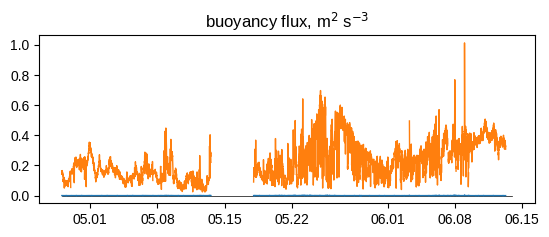

In [21]:
rc("font", family="Liberation Sans")

# plot buoyancy flux
clf()
subplot(2,1,1)
plot(psltime[[1, end]], [0, 0], color="k", linewidth=0.5)
plot(psltime[:], bflx0, linewidth=1, label="OSU: sfc T,q")
# plot(psltime[:], bflxa, linewidth=0.5, label="OSU: air T,q")
# plot(psltime[:], psl[:hb_bulk][:]/3.5e4, linewidth=0.5, label="PSL × g/(ρCpT)") # not in the new file
plot(psltime[:], psl["ustar"][:], linewidth=1)
title("buoyancy flux, m"*L"^2"*" s"*L"^{-3}")
# legend()
gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%m.%d"))
# subplot(2,1,2)
# plot(psl[:time][[1, end]], [0, 0], color="k", linewidth=0.5)
# plot(psl[:time][:], -psl[:hl_bulk][:], linewidth=1, label="lat")
# plot(psl[:time][:], -psl[:hs_bulk][:], linewidth=1, label="sen")
# gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%m.%d"))
gcf()

# To get from PSL's dynamic heat flux units for hb_bulk (W/m^2) to buoyancy flux (m^2/s^-3), one multiplies hb_bulk by 
# g / (rho*Cp*T).


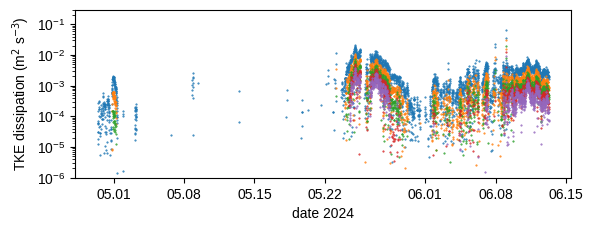

In [30]:
# surface dissipation based on ustar^3
function phi_epsilon(zet) 
    if !ismissing(zet)
        zet<0.1 ? 0.8 + 2*zet : sqrt(zet/0.1) # Hartogensis and De Bruin
    else
        missing
    end
end

# 5.0 ./ psl[:mo_length][:]
# let z = 5, vonk=0.4
#     ustar = psl[:ustar][:]
#     mo_length = psl[:mo_length][:]
#     zet = z ./ mo_length
#     phi_epsilon.(zet) .* ustar.^3 ./ (vonk.*z)
# end

function sfc_epsilon(z; vonk=0.4, mo_length=psl[:mo_length][:], ustar=psl[:ustar][:])
    zet = z ./ mo_length
    phi_epsilon.(zet) .* ustar.^3 ./ (vonk.*z)
end

m2f(x) = ismissing(x) ? false : x

sfc_epsilon(5.0; vonk=0.4)
epsilon0 = hcat([ sfc_epsilon(z) for z in 17.0.+height[1:5] ]...)

posgood(x) = good(x) && x>0
pp = findall( posgood.(epsilon0[:,1]) )

clf()
subplot(2,1,1)
semilogy(psl[:time][pp], epsilon0[pp,:], marker=".", markersize=1, linestyle="none")
ylim([1e-6, 3e-1])
gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%m.%d"))
ylabel("TKE dissipation (m\$^2\$ s\$^{-3}\$)")
xlabel("date 2024")
gcf()

sys:1: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.


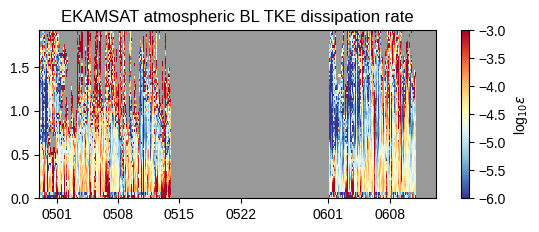

In [32]:
plotfilt(x) = (ismissing(x) || x<=0) ? NaN : x
clean(x) = x<=0 ? missing : x

clf()
subplot(2,1,1)
pcolor(start_dt, height/1e3, log10.(plotfilt.(pd(epsi))), vmin = -6, vmax = -3,
        cmap=ColorMap("RdYlBu_r"))
gca().set_facecolor(0.6.+[0,0,0])
gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%m%d"))
title("EKAMSAT atmospheric BL TKE dissipation rate")
cb = colorbar(); cb.set_label("log"*L"_{10}\epsilon")
gcf()

In [31]:
# methods for averaging DateTimes and TimePeriod

"dt(dt, ...)"
function accudt(f, dt::AbstractVector{DateTime}, args...)
    ms = @. Dates.value(Millisecond(dt - dt[1]))
    return dt[1] .+ Millisecond(round(Int64, f(ms, args...)))
end
# "mean for datetimes" updated 2024-08-01
# meandt(dt::AbstractVector{DateTime}) = first(dt) + MRi( mean(DVM.(dt .- first(dt))) )
"meandt(t, ...)"
function accudt(f, dt::AbstractVector{T}, args...) where T<:TimePeriod
    ms = @. Dates.value(Millisecond(dt))
    return Millisecond(round(Int64, f(ms, args...)))
end

meandt(end_dt .- start_dt) / Millisecond(60_000)
meandt(diff(start_dt)) / Millisecond(60_000)

accudt(median, end_dt .- start_dt) / Millisecond(60_000) # 9:08
accudt(median, diff(start_dt)) / Millisecond(60_000)


UndefVarError: UndefVarError: `meandt` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

sys:1: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.


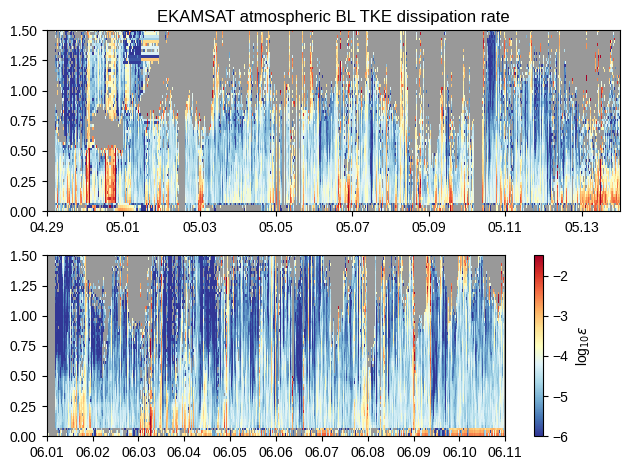

In [33]:
clf()
subplot(2,1,1)
pcolormesh(start_dt, height/1e3, log10.(plotfilt.(pd(epsi))), vmin = -6, vmax = -1.5,
        cmap=ColorMap("RdYlBu_r"))
pcolormesh(psl[:time], height[1:4]/1e3, log10.(plotfilt.(pd(epsilon0[:,1:4]))), vmin = -6, vmax = -1.5,
        cmap=ColorMap("RdYlBu_r"))
gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%m%d"))
title("EKAMSAT atmospheric BL TKE dissipation rate")
# plot(psl[:time][:], 0.5*psl[:prate][:], linewidth=0.5, color="blue")
# plot(psl[:time][:], 0.1*psl[:wspd_10][:], linewidth=0.5, color="k")
# plot(psl[:time][:], 0.1*psl[:rspd][:], linewidth=0.5, color="k")
# # plot(psl[:time][:], 0.75 .+ 0.75/180*psl[:rdir][:], linewidth=0.5, color="m")
# plot(psl[:time][:], 1000*bflx0, linewidth=0.5, color="r")
xlim([DateTime(2024,4,29), DateTime(2024,5,14)])
# xlim([DateTime(2024,5,2), DateTime(2024,5,4)])
ylim([0, 1.5])
gca().set_facecolor(0.6.+[0,0,0])
gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%m.%d"))

subplot(2,1,2)
pcolormesh(psl[:time], height[1:4]/1e3, log10.(plotfilt.(pd(epsilon0[:,1:4]))), vmin = -6, vmax = -1.5,
        cmap=ColorMap("RdYlBu_r"))
pcolormesh(start_dt, height/1e3, log10.(plotfilt.(pd(epsi))), vmin = -6, vmax = -1.5,
        cmap=ColorMap("RdYlBu_r"))
# plot(psl[:time][:], 0.5*psl[:prate][:], linewidth=0.5, color="blue")
# plot(psl[:time][:], 0.1*psl[:wspd_10][:], linewidth=0.5, color="k")
# plot(psl[:time][:], 0.1*psl[:rspd][:], linewidth=0.5, color="k")
# # plot(psl[:time][:], 0.75 .+ 0.75/180*psl[:rdir][:], linewidth=0.5, color="m")
# plot(psl[:time][:], 1000*bflx0, linewidth=0.5, color="r")
xlim([DateTime(2024,6,1), DateTime(2024,6,11)])
# xlim([DateTime(2024,6,2), DateTime(2024,6,4)])
ylim([0, 1.5])
gca().set_facecolor(0.6.+[0,0,0])
gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%m.%d"))
cb = colorbar(); cb.set_label("log"*L"_{10}\epsilon")
tight_layout()
gcf()

savefig("ekamsat_MABL_TKEdissipation.png", dpi=400)
# savefig("ekamsat_MABL_TKEdissipation.pdf") # slow
# savefig("ekamsat_MABL_TKEdissipation.svg") # slow
gcf()

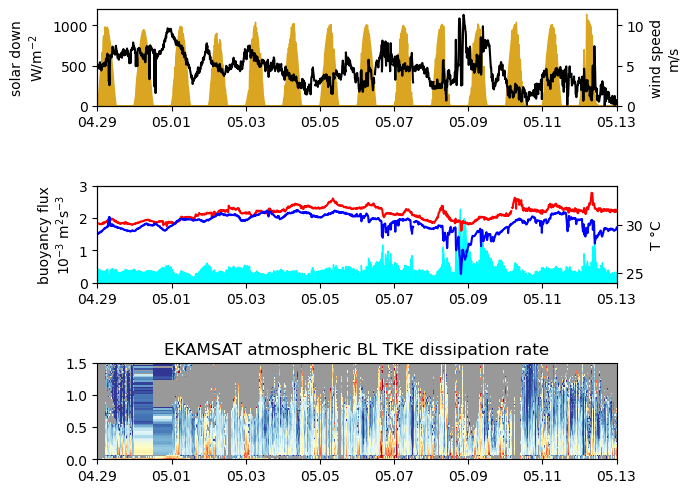

In [ ]:
# replicate DYNAMO plot
tstart = DateTime(2024,4,29)
tend = DateTime(2024,5,13)
clf()
ltax1 = subplot(3,1,1)
rtax1 = ltax1.twinx()
ltax1.fill_between(psl[:time][:], psl[:sw_down][:], color="goldenrod", label="solar down, W/m\$^{-2}\$")
rtax1.plot(psl[:time][:], psl[:wspd_10][:], color="k", label="10 m wind speed, m/s")
ltax1.set_xlim([DateTime(2024,4,29), tend])
rtax1.set_xlim([DateTime(2024,4,29), tend])
ltax1.set_ylim([0, 1200])
rtax1.set_ylim([0, 12])
ltax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%m.%d"))
ltax1.set_ylabel("solar down\nW/m\$^{-2}\$")
rtax1.set_ylabel("wind speed\nm/s")

ltax2 = subplot(3,1,2)
rtax2 = ltax2.twinx()
ltax2.fill_between(psl[:time][:], 1e3*bflx0, color="cyan", label="buoyancy flux")
rtax2.plot(psl[:time][:], psl[:tskin][:], color="r", label="SST")
rtax2.plot(psl[:time][:], psl[:tair][:], color="b", label="Tair")
ltax2.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%m.%d"))
ltax2.set_ylim([0, 3])
rtax2.set_ylim([24, 34])
ltax2.set_xlim([DateTime(2024,4,29), tend])
rtax2.set_xlim([DateTime(2024,4,29), tend])
ltax2.set_ylabel("buoyancy flux\n10\$^{-3}\$ m\$^2\$s\$^{-3}\$")
rtax2.set_ylabel("T °C")

ax3 = subplot(3,1,3)
pcolormesh(start_dt, height/1e3, log10.(plotfilt.(pd(epsi))), vmin = -6, vmax = -1.5,
        cmap=ColorMap("RdYlBu_r"))
pcolormesh(psl[:time], height[1:4]/1e3, log10.(plotfilt.(pd(epsilon0[:,1:4]))), vmin = -6, vmax = -1.5,
        cmap=ColorMap("RdYlBu_r"))
ax3.set_title("EKAMSAT atmospheric BL TKE dissipation rate")
ax3.set_xlim([tstart, tend])
ax3.set_ylim([0, 1.5])
ax3.set_facecolor(0.6.+[0,0,0])
ax3.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%m.%d"))
gcf()


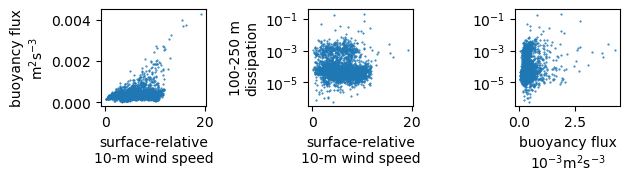

In [166]:
# interpolate psl to lidar time
"convert datetime to Integer milliseconds, which interpolate can handle."
dt2ms(dt, dt0=DateTime(2024,4,1)) = Dates.value(Millisecond(dt - dt0))
"interpolate from psl datetime to lidar dt"
interp_psl_to_lidar(y; psldt=psl[:time][:], lidardt=start_dt) = 
    interpolate( (dt2ms.(psldt), ), y, Gridded(Linear()) )(dt2ms.(lidardt)) # returns a vector
# use-test
bflxi = interp_psl_to_lidar(bflx0)
wspdi = interp_psl_to_lidar(psl[:wspd_10][:])
size(bflxi), size(wspdi), size(start_dt), size(epsi)
clf()
plot(wspdi[si][1:nf], (1:nf)/nf, marker=".", markersize=1, linestyle="none")
gcf()

clf()
subplot(3,3,1)
plot(wspdi[si][1:nf], bflxi[si][1:nf], marker=".", markersize=1, linestyle="none")
ylabel("buoyancy flux\nm\$^2\$s\$^{-3}\$")
xlabel("surface-relative\n10-m wind speed")
subplot(3,3,2)
semilogy(wspdi[si][1:nf], (epsNrSfc[si][1:nf]), marker=".", markersize=1, linestyle="none")
ylabel("100-250 m\ndissipation")
xlabel("surface-relative\n10-m wind speed")
subplot(3,3,3)
semilogy(1e3.*bflxi[si][1:nf], (epsNrSfc[si][1:nf]), marker=".", markersize=1, linestyle="none")
xlabel("buoyancy flux\n10\$^{-3}\$m\$^2\$s\$^{-3}\$")
# ylabel("100-250 m\ndissipation")
tight_layout()
gcf()

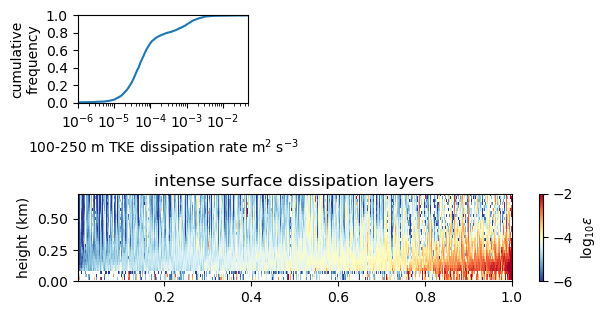

In [132]:
# plot intense surface dissipation

isgood(x) = !ismissing(x) && isfinite(x) && x>=0
good(x) = isgood(x) ? x : 0
goodmean(x; dims) = sum(good.(x), dims=dims)./sum(isgood.(x), dims=dims)

# 100-250 m mean dissipation
epsNrSfc = goodmean(epsi[:,5:10], dims=2)[:,1]
height[1:10]

si = sortperm(epsNrSfc)
nf = sum(isfinite.(epsNrSfc))
irg = 1:nf

clf()
subplot(3,3,1)
semilogx(epsNrSfc[si][irg], (1:nf)/nf)
# plot(bflxi[si][1:nf], (1:nf)/nf, marker=".", markersize=1, linestyle="none")
plot(wspdi[si][1:nf], (1:nf)/nf, marker=".", markersize=1, linestyle="none")
ylim([-0.001, 1.001])
xlim([1e-6, 5e-2])
xlabel("100-250 m TKE dissipation rate m\$^2\$ s\$^{-3}\$")
ylabel("cumulative\nfrequency")
yticks(0:0.2:1)

subplot(3,1,2)
pcolormesh(irg/nf, height/1e3, log10.(pd(epsi[si[irg][1:nf-1],1:ntop-1])), 
    vmin=-6, vmax=-2, cmap=ColorMap("RdYlBu_r"))
# gca().set_facecolor(0.6.+[0,0,0])
ylabel("height (km)")
cb = colorbar(); cb.set_label("log"*L"_{10}\epsilon")
ylim([0, 0.7])
title("intense surface dissipation layers")
tight_layout()
gcf()

Bimodal distribution of TKE dissipation rate. 

Main mode, with 0.8 observations, is around 5x10^-5.

About 1/5 of 100-250 m epsilon measurements are in a secondary (higher)
mode around 10^-3 m^2/s^3.

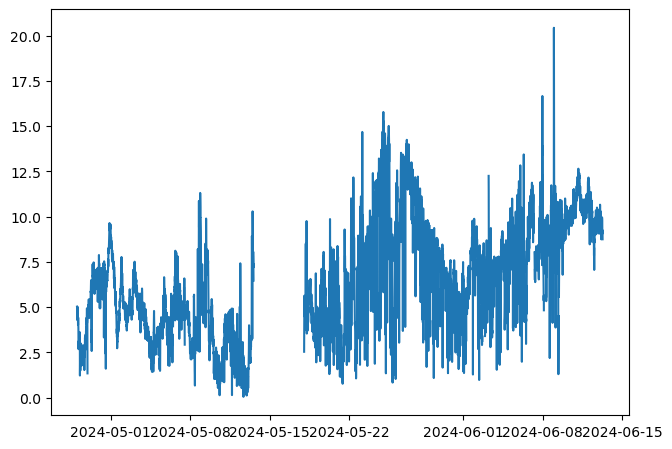

In [399]:
clf()
plot(psl[:time][:], psl[:wspd_10][:])
gcf()

In [41]:
size(epsi)
eachrow(epsi)

4743-element RowSlices{Matrix{Union{Missing, Float64}}, Tuple{Base.OneTo{Int64}}, SubArray{Union{Missing, Float64}, 1, Matrix{Union{Missing, Float64}}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}}:
 [-5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0  …  -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0]
 [-5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0  …  -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0]
 [-5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0  …  -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0]
 [-5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0  …  -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0]
 [-5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0  …  -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0]
 [-5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0  …  -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0]
 [-5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -

In [ ]:
# diagnose mixed layer depth

iz = axes(epsi,2)
"Compute MLD index for a profile."
mldi(epsi, fac=3) = findfirst( fac.*iz.*epsi .< cumsum(epsi) )
map(mldi, max(0,eachrow(epsi)))